In [3]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
import pandas as pd
import numpy as np
import pandas.io.sql as pd_sql
import sqlite3 as sql
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier, 
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier)
from sklearn.linear_model import (LinearRegression, LogisticRegressionCV, 
    LogisticRegression, SGDClassifier, Ridge, Lasso, ElasticNet, LassoCV, RidgeCV, ElasticNetCV)
from sklearn.svm import LinearSVC, NuSVC, SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.neural_network import MLPClassifier

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate, GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score,confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import preprocessing

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix
from yellowbrick.features import FeatureImportances

from imblearn.over_sampling import SMOTE
import os
from sklearn.tree import export_graphviz
import pydot

%matplotlib inline

In [28]:
con = sql.connect('/Users/georgebrooks/Documents/Box-Office/database/movies.db')
data = pd_sql.read_sql('select * from finalMovies_20180814', con, index_col='index')

In [29]:
#Limit dataset to those with filled in Revenue, Budget, and Length columns.  Based on what I've seen, this helps to
#get rid of remaining duplicates in dataset.  Also helps to narrow down dataset to test profitability, where we
#need both revenue and budget filled in.  We could experiment with movies with revenue greater than $500,000, if 
#we choose to.
movies = data[(data['Revenue_Real']>0)&(data['Budget_Real']>0)&(data['Length']>0)]

#Make binary variable for if movie made at least 2x budget
movies['Profit_Bucket_Binary']=np.where(movies['Profit_Bucket']=='<1x', 0, np.where(movies['Profit_Bucket']=='[1-2x)', 
                        0, np.where(movies['Profit_Bucket']=='[2-3x)', 1, np.where(movies['Profit_Bucket']=='[3-4x)', 
                        1, np.where(movies['Profit_Bucket']=='[4-5x)', 1, np.where(movies['Profit_Bucket']=='>=5x', 1, ''))))))

#Put zero where null
movies['Revenue_Actor_Real']=movies['Revenue_Actor_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
movies['Revenue_Director_Real']=movies['Revenue_Director_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
movies['Revenue_Writer_Real']=movies['Revenue_Writer_Real'].apply(lambda x: 0 if pd.isnull(x) else x)

0    2539
1    1875
Name: Profit_Bucket_Binary, dtype: int64


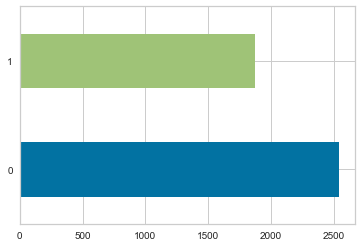

In [30]:
#Show distribution of profit bucket binary
print(movies['Profit_Bucket_Binary'].value_counts())
movies['Profit_Bucket_Binary'].value_counts().plot(kind='barh')
plt.show()

In [31]:
#Set X, y
X = movies[["Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real']]
y = movies["Profit_Bucket_Binary"]

In [32]:
scaler = StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
X_std = min_max_scaler.fit_transform(X)

In [33]:
#Use YellowBrick Visualizations to get initial look at Classification Reports and ROC AUC curves
#This is use a simple train/test split
seed=3
X_train_std, X_test_std, y_train_std, y_test_std = \
    cross_validation.train_test_split(X_std, y, test_size = 0.2, random_state=seed)

In [34]:
classifiers = [
    LogisticRegressionCV(random_state=1, cv=5), #, class_weight = 'balanced'),
    LogisticRegression(random_state=1), #, class_weight = 'balanced'),
    RandomForestClassifier(n_estimators=50, oob_score=True), #, class_weight = 'balanced'),
    XGBClassifier(),#scale_pos_weight = 1.35),   
    BaggingClassifier(), 
    ExtraTreesClassifier(),  #, class_weight = 'balanced'),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    MultinomialNB(),
    GaussianNB(),
    SGDClassifier(), #, class_weight = 'balanced'), ##ROC AUC not printing out properly
    MLPClassifier(),
    SVC(kernel='linear'), #, class_weight = 'balanced'), ##ROC AUC not printing out properly
    SVC(kernel='rbf'), #, class_weight = 'balanced'),
    SVC(kernel='poly', degree=3), #, class_weight = 'balanced'),
    KNeighborsClassifier()
]

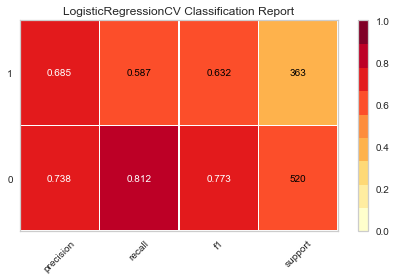

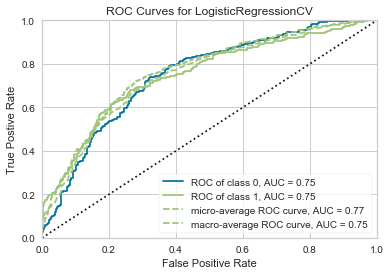

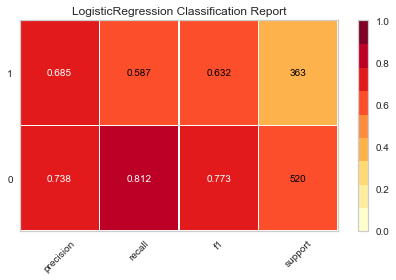

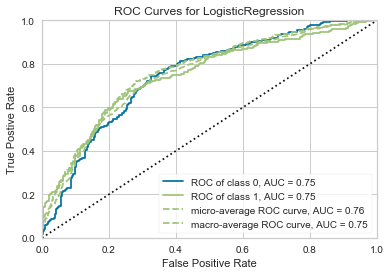

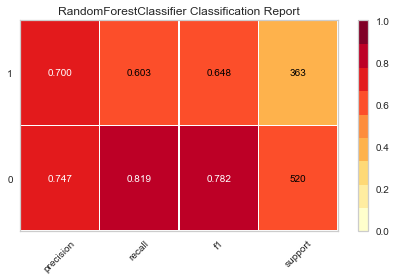

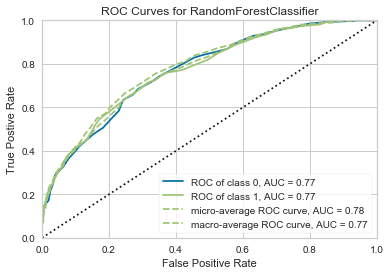

/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


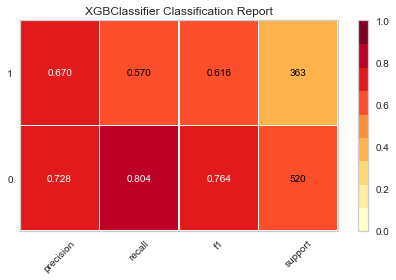

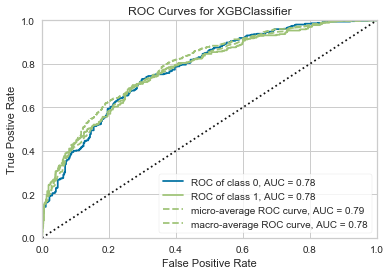

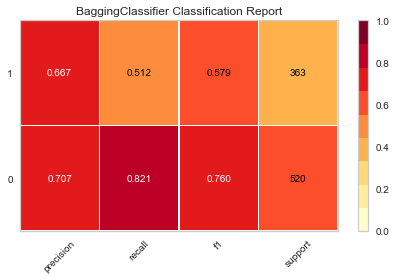

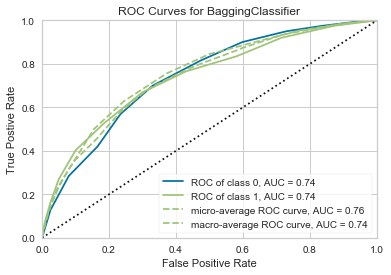

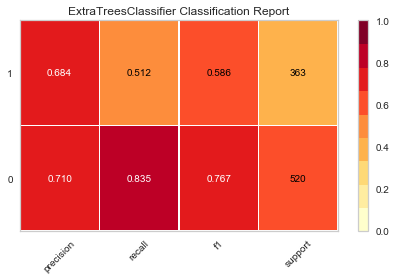

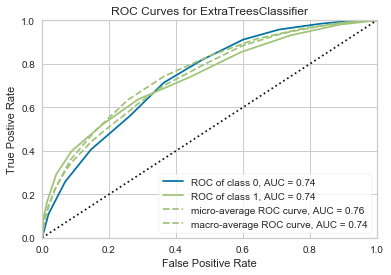

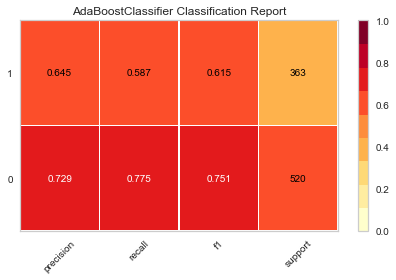

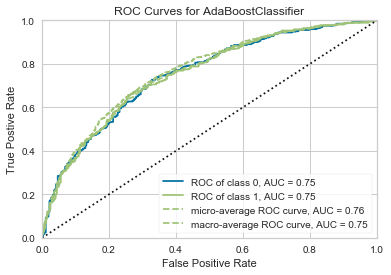

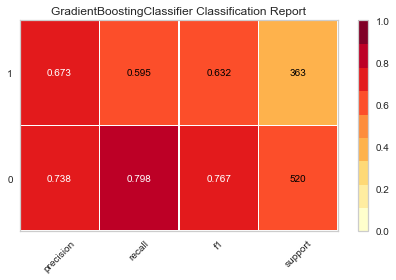

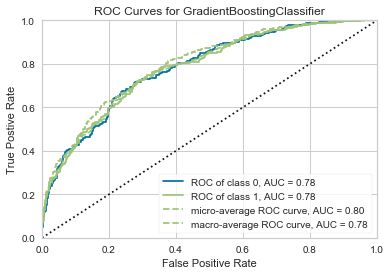

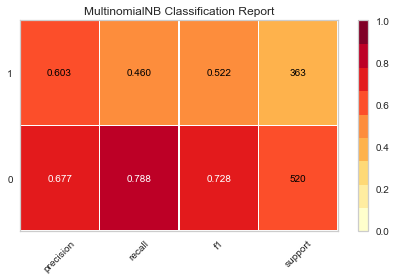

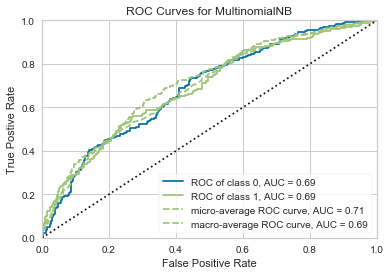

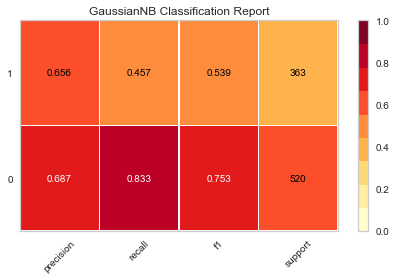

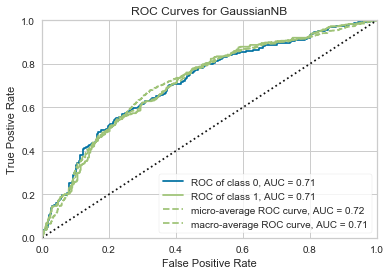

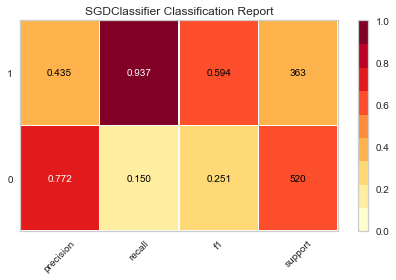

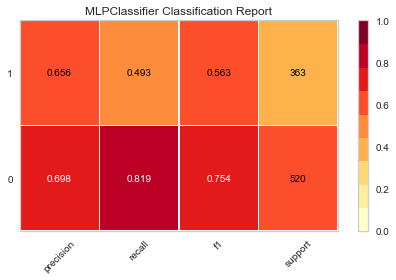

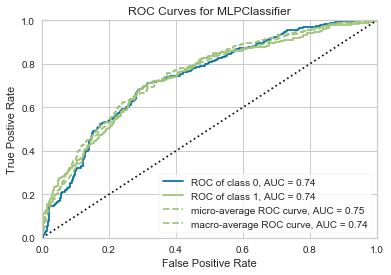

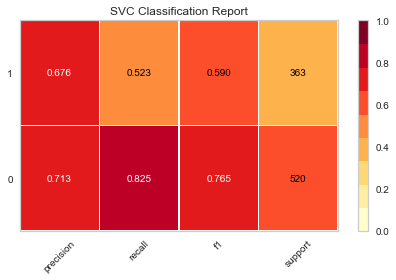

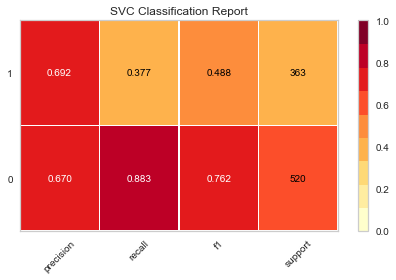

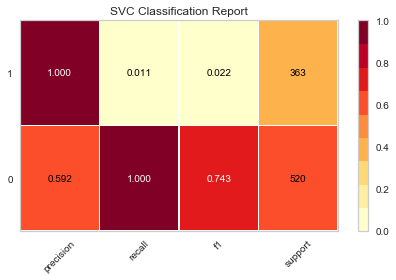

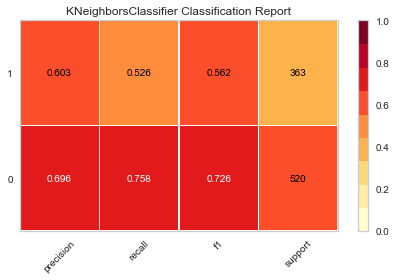

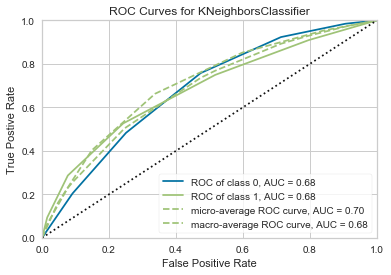

In [35]:
for clf in classifiers:

    name = clf.__class__.__name__
    
    oz = ClassificationReport(clf, support=True)
    oz.fit(X_train_std, y_train_std)
    oz.score(X_test_std, y_test_std)
    oz.poof()
    
    if name != "SGDClassifier" and name != "SVC":
        label_encoder = LabelEncoder()
        yc = label_encoder.fit_transform(y)
        oz = ROCAUC(clf, support=True, classes=label_encoder.classes_)
        oz.fit(X_train_std, y_train_std)
        oz.score(X_test_std, y_test_std)
        oz.poof()

    ###Other YellowBrick viz
    #oz=FeatureImportances(clf)
    #oz.fit(X_train, y_train)
    #oz.poof()

In [36]:
#Use K-fold cross validation to further examine some of the better models.
#Based on the classification reports above, let's examine the better models. Make the cutoff for models at least 0.60 F1 score for detecting a profitable movie (i.e, the Profit Bucket Binary variable = 1): Logistic Regression, Random Forest, XGBoost, AdaBoost, Gradient Boosting, MLP, SVC(rbf/linear). Keeping SVC because it was borderline ~0.59. Also adding Voting Classifier to see if it can do better by combing multiple models.

#For each potential classification model and print out Accuracy, Precision, Recall, F1, ROC_AUC using k-fold cross validation.

#sm = SMOTE(random_state=12)
#X_std_SMOTE, y_SMOTE = sm.fit_sample(X_std, y)

In [37]:
classifiers = [
    LogisticRegressionCV(random_state=1, cv=5), #, class_weight = 'balanced'),
    LogisticRegression(random_state=1), #, class_weight = 'balanced'),
    RandomForestClassifier(n_estimators=50, oob_score=True), #, class_weight = 'balanced'),
    XGBClassifier(),#scale_pos_weight = 1.35),      
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier(),
    SGDClassifier(),
    SVC(kernel='linear'), #, class_weight = 'balanced'), ##ROC AUC not printing out properly
    SVC(kernel='rbf'), #, class_weight = 'balanced'),
    VotingClassifier(estimators=[('lr', LogisticRegressionCV(random_state=1, cv=5)), 
                                 ('rf', RandomForestClassifier(n_estimators=50, oob_score=True)), 
                                 ('xbg', XGBClassifier()),
                                 ('ad', AdaBoostClassifier()), 
                                 ('gb', GradientBoostingClassifier()), 
                                 ('mlp', MLPClassifier())],
                                 #('sv', SVC(kernel='rbf'))],
                                voting='soft')
]

In [15]:
for clf in classifiers:

    name = clf.__class__.__name__
    y_int = y.astype(int)
    #y_int_SMOTE = y_SMOTE.astype(int)
    scoring_list = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    scores = cross_validate(clf, X_std, y_int, cv=10, scoring=scoring_list, return_train_score=False)  
    #scores_SMOTE = cross_validate(clf, X_std_SMOTE, y_int_SMOTE, cv=10, scoring=scoring_list, return_train_score=False)
    
    print(name, #'\t', '\t' , '\t' , '\t' ,'\t', name, "SMOTE",
          '\n', "\tAccuracy:",scores['test_accuracy'].mean(),
              #"\t\t\t\tAccuracy:",scores_SMOTE['test_accuracy'].mean(),
          '\n', "\tPrecision:", scores['test_precision'].mean(), 
              #"\t\t\t\tPrecision:", scores_SMOTE['test_precision'].mean(),
          '\n', "\tRecall:", scores['test_recall'].mean(), 
              #"\t\t\t\tRecall:", scores_SMOTE['test_recall'].mean(),
          '\n', "\tF1:", scores['test_f1'].mean(), 
              #"\t\t\t\t\tF1:", scores_SMOTE['test_f1'].mean(),
          '\n', "\tROC_AUC:", scores['test_roc_auc'].mean(), 
              #"\t\t\t\tROC_AUC:", scores_SMOTE['test_roc_auc'].mean(),
          '\n' 
         )    
    #y_pred = cross_val_predict(clf,X_std,y,cv=10)
    #class_report = classification_report(y,y_pred)
    #print(name, '\n', class_report)

LogisticRegressionCV 
 	Accuracy: 0.7070378571008823 
 	Precision: 0.6937774442813663 
 	Recall: 0.558900329957902 
 	F1: 0.6180559706617207 
 	ROC_AUC: 0.7656328045613587 

LogisticRegression 
 	Accuracy: 0.7083999473915441 
 	Precision: 0.6960145839320132 
 	Recall: 0.5605017635680964 
 	F1: 0.6199658945977727 
 	ROC_AUC: 0.7653048739303264 

RandomForestClassifier 
 	Accuracy: 0.7235947805695705 
 	Precision: 0.7237962616812493 
 	Recall: 0.5695613835476163 
 	F1: 0.6364352100724052 
 	ROC_AUC: 0.7839755498081707 



/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

XGBClassifier 
 	Accuracy: 0.7208695762687359 
 	Precision: 0.7205401608394181 
 	Recall: 0.563155649106838 
 	F1: 0.6313246980310022 
 	ROC_AUC: 0.788004135395364 

AdaBoostClassifier 
 	Accuracy: 0.7142915487873471 
 	Precision: 0.6997704643890812 
 	Recall: 0.5796734554556833 
 	F1: 0.6327899528730555 
 	ROC_AUC: 0.7750202907020409 

GradientBoostingClassifier 
 	Accuracy: 0.7235809055556955 
 	Precision: 0.7202796997837917 
 	Recall: 0.5738053248378655 
 	F1: 0.6378465767124888 
 	ROC_AUC: 0.7907948345856549 



/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier 
 	Accuracy: 0.6895877884953514 
 	Precision: 0.6486792811128778 
 	Recall: 0.5982591876208898 
 	F1: 0.6180777651751846 
 	ROC_AUC: 0.7461996956498049 

SGDClassifier 
 	Accuracy: 0.6490561609259089 
 	Precision: 0.6356267558892501 
 	Recall: 0.507483786551371 
 	F1: 0.5197161224909426 
 	ROC_AUC: 0.7143337258778977 

SVC 
 	Accuracy: 0.7038683911793157 
 	Precision: 0.7164744767801533 
 	Recall: 0.5066361360791899 
 	F1: 0.5920115933947159 
 	ROC_AUC: 0.7639570716058176 

SVC 
 	Accuracy: 0.682122741870641 
 	Precision: 0.7607648945287517 
 	Recall: 0.3706621913755831 
 	F1: 0.49664256592761047 
 	ROC_AUC: 0.7618783982438148 



/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

VotingClassifier 
 	Accuracy: 0.7260695980023713 
 	Precision: 0.7242235852114882 
 	Recall: 0.576993969734896 
 	F1: 0.6411592975150612 
 	ROC_AUC: 0.7948689935765754 



/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

In [16]:
#A look at feature importances.
#For the classifiers that have the ability to give a ranking of feature importances, plot top 10 features.

classifiers = [
    LogisticRegressionCV(random_state=1, cv=5),
    LogisticRegression(random_state=1),
    RandomForestClassifier(n_estimators=50, oob_score=True),
    XGBClassifier(),  
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(), 
    SVC(kernel='linear')
]

##Adapted code to determine most important feature from here:
##https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train_std, y_train_std)
    temp = pd.DataFrame(X_train_std, columns=X.columns)

    if name != "LogisticRegressionCV" and name != "LogisticRegression" and \
        name != "MultinomialNB" and name != "SGDClassifier" and \
        name != "SVC":
        feature_importances = pd.DataFrame(clf.feature_importances_,
           index = temp.columns,columns=['importance']).sort_values('importance',
            ascending=False)
        print(name, '\n',feature_importances.head(15))
        print('\n')
        
    elif name == "LogisticRegressionCV" or name == "LogisticRegression" or \
        name == "SGDClassifier" or name == "SVC":
        feature_importances = pd.DataFrame(clf.coef_.transpose(),
        index = temp.columns,columns=['importance']).sort_values('importance',
            ascending=False)
        print(name, '\n', feature_importances.abs().sort_values(by='importance', ascending=False).head(15))
        print('\n')        
        
    else:
        feature_importances = pd.DataFrame(clf.coef_.transpose(),
        index = temp.columns,columns=['importance']).sort_values('importance',
            ascending=False)
        print(name, '\n', feature_importances.head(15))
        print('\n')

LogisticRegressionCV 
                        importance
Rating_IMDB              2.160716
isCollection             1.690211
Comp_Disney              1.226569
Rating_RT                1.221678
Revenue_Director_Real    1.161104
Comp_Fox                 1.058120
Comp_Universal           0.678629
Comp_Sony                0.671670
Comp_Lionsgate           0.611309
Comp_Paramount           0.600126
Budget_Real              0.583579
Revenue_Actor_Real       0.565540
Genre_Drama              0.556704
Rating_Metacritic        0.545392
Revenue_Writer_Real      0.479345


LogisticRegression 
                        importance
Rating_IMDB              2.669530
isCollection             1.741557
Revenue_Director_Real    1.625935
Comp_Disney              1.378386
Rating_RT                1.264260
Comp_Fox                 1.128552
Budget_Real              1.068928
Revenue_Writer_Real      0.969964
Rated_Other              0.946698
Rated_R                  0.739619
Comp_Universal           0.739188
Co

In [17]:
#Next, perform hyperparameter tuning on some of the better models
#See if classifiers perform better with tuning of hyperparameters. We will then place some of the best ones into a Voting Classifier and have it decide the best combination of models.

#Caution: The Gradient Booster and Voting Classifier grid searches take a few hours to run.

#SVC grid search

parameters = {'kernel':('linear', 'rbf', 'poly'), 
              'C':[1, 2,3,4,5,6,7,8,9, 10],
              'class_weight': [None, 'balanced']}

y_train_std_int = y_train_std.astype(int)
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='f1')
clf.fit(X_train_std, y_train_std_int)

print("Best parameters set found for SVC:")
print()
print(clf.best_params_)

/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/georgebrooks/anaconda3/li

Best parameters set found for SVC:

{'C': 8, 'class_weight': 'balanced', 'kernel': 'rbf'}


In [18]:
#Random Forest grid search

parameters = {'n_estimators':(1,20,40,60,80,100), 
              'max_features':[None, 'auto', 'log2'], 
              'max_depth': [1,10,20], 
              'class_weight': [None, 'balanced'],
              'oob_score': [True, False]}

y_train_std_int = y_train_std.astype(int)
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, scoring='f1')
clf.fit(X_train_std, y_train_std_int)

print("Best parameters set found for Random Forest:")
print()
print(clf.best_params_)

/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute an

/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute an

/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Best parameters set found for Random Forest:

{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100, 'oob_score': True}


In [19]:
#Logistic Regression grid search

parameters = {'penalty':['l1', 'l2'], 
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'class_weight': [None, 'balanced']}

y_train_std_int = y_train_std.astype(int)
lr = LogisticRegression(random_state=1)
clf = GridSearchCV(lr, parameters, scoring='f1')
clf.fit(X_train_std, y_train_std_int)

print("Best parameters set found for Logistic Regression:")
print()
print(clf.best_params_)

/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/georgebrooks/anaconda3/li

Best parameters set found for Logistic Regression:

{'C': 10, 'class_weight': 'balanced', 'penalty': 'l2'}


In [20]:
#Ada Boost grid search

parameters = {'n_estimators':(1,20,40,60,80,100, 120, 140, 160)}

y_train_std_int = y_train_std.astype(int)
ad = AdaBoostClassifier()
clf = GridSearchCV(ad, parameters, scoring='f1')
clf.fit(X_train_std, y_train_std_int)

print("Best parameters set found for AdaBoost:")
print()
print(clf.best_params_)

Best parameters set found for AdaBoost:

{'n_estimators': 120}


In [21]:
#XGBoost grid search

parameters = {'scale_pos_weight' : [1,1.35, 1.5, 2, 2.5, 3, 4]}

y_train_std_int = y_train_std.astype(int)
xgb = XGBClassifier()
clf = GridSearchCV(xgb, parameters, scoring='f1')
clf.fit(X_train_std, y_train_std_int)

print("Best parameters set found for XGBoost:")
print()
print(clf.best_params_)

/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

Best parameters set found for XGBoost:

{'scale_pos_weight': 2}


/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


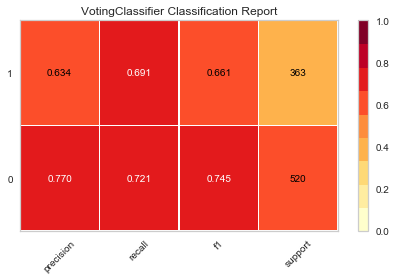

/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/georgebrooks/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


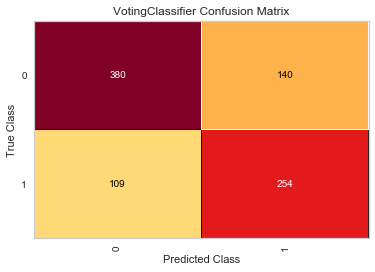

In [22]:
vc_final = VotingClassifier(estimators=[('lrcv', LogisticRegressionCV(random_state=1, cv=5)), 
                                  ('lr', LogisticRegression(C= 10, class_weight= None, penalty= 'l1',random_state=1)),
                                 ('rf', RandomForestClassifier(class_weight= 'balanced', max_depth= 10, max_features= 'log2', n_estimators= 60, oob_score=False)), 
                                 ('xbg', XGBClassifier(scale_pos_weight= 2)),
                                 ('ad', AdaBoostClassifier(n_estimators= 120)), 
                                 ('gb', GradientBoostingClassifier(criterion= 'friedman_mse', loss= 'exponential', max_depth= 5, max_features= 'log2', n_estimators= 120)), 
                                 ('mlp', MLPClassifier())], 
                     weights = [0, 0, 1, 1, 0, 0, 1],
                     voting = 'hard')


name = vc_final.__class__.__name__

oz = ClassificationReport(vc_final, support=True)
oz.fit(X_train_std, y_train_std)
oz.score(X_test_std, y_test_std)
oz.poof()

oz = ConfusionMatrix(vc_final)
oz.fit(X_train_std, y_train_std)
oz.score(X_test_std, y_test_std)
oz.poof()

##ROC AUC not working
#label_encoder = LabelEncoder()
#yc = label_encoder.fit_transform(y)
##oz = ROCAUC(vc, support=True, classes=label_encoder.classes_)
#oz.fit(X_train_std, y_train_std)
#oz.score(X_test_std, y_test_std)
#oz.poof()

In [ ]:
##Code to store lasso model in GitHub.  Commented out to prevent writing over current model.
#two_up = os.path.abspath(os.path.join(os.getcwd(),"../.."))
#filename = two_up + r'\final_models\votingClassifier_20180901.pkl'
#joblib.dump(vc_final, filename)

In [ ]:
#Code to double check stored Voting Classifier model is the same as what was created above.

#two_up = os.path.abspath(os.path.join(os.getcwd(),"../.."))
filename = two_up + r'\final_models\votingClassifier_20180901.pkl'
vc_check = joblib.load(filename)
print(vc_check)
oz = ClassificationReport(vc_check, support=True)
oz.fit(X_train_std, y_train_std)
oz.score(X_test_std, y_test_std)
oz.poof()

In [24]:
#import pickle library
#import pickle

In [38]:
#create the path files
#model_file_path = os.path.join(os.path.pardir,'models','lr_modelpkl')
#scaler_file_path = os.path.join(os.path.pardir,'models','lr_scaler.pkl')

In [40]:
#open the files to write
#model_file_pickle = open(model_file_path, 'wb')
#scaler_file_pickle = open(scaler_file_path, 'wb')

In [46]:
# Save Model Using joblib
import pandas
from sklearn import model_selection
from sklearn.linear_model import Lasso
from sklearn.externals import joblib
url = "https://github.com/georgetown-analytics/Box-Office/blob/master/database/movies.db"
names = ["Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real']
dataframe = pd.read_sql(con, names=names)
#dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
test_size = 0.2
seed = 3
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
# Fit the model on 33%
model = LogisticRegression()
model.fit(X_train, Y_train)
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(model, filename)
 
# some time later...
 
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, Y_test)
print(result)


TypeError: read_sql() got an unexpected keyword argument 'names'